#**IBM Telco Customer Churn Analysis**

https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113


The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

# **1. Using XGBoost**





In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
openjdk version "11.0.9" 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


In [3]:
! pip install h2o

     |████████████████████████████████| 129.4MB 95kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.3-py2.py3-none-any.whl size=129446676 sha256=9a0fe77556018c208472059c45f57b5eaeb3d55118e86f3a1b8938b1de407087
  Stored in directory: /root/.cache/pip/wheels/3d/e6/07/53ce9be9cb61b33a79cb3ed1fc39f2dae84f6ee6fe1e373e5e
Successfully built h2o


In [4]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpni5zn2fy
  JVM stdout: /tmp/tmpni5zn2fy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpni5zn2fy/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_geyjd2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
!pwd

/content


In [6]:
!ls /content/drive/My\ Drive/DataFiles

Telco-Customer-Churn-IBM.csv


In [7]:
%cd /content/drive/My Drive/DataFiles
# "%" is used to store the path
# "!" is used to run a unix command

/content/drive/My Drive/DataFiles


In [8]:
df = pd.read_csv("Telco-Customer-Churn-IBM.csv")

In [9]:
df.shape

(7043, 21)

In [10]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [11]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', df.shape[0]+1)

In [ ]:
# Blank space removal
# It's best practice to remove white spaces in both data and column names to help with plotting

# If there are white spaces in the columns, we need to replace them accordingly
df.columns = df.columns.str.replace(' ', '_')

# Replacing white spaces " " with "_" in data
df['MultipleLines'].replace(' ', '_', regex = True, inplace = True)
df.replace(' ', '_', regex = True, inplace = True)

In [ ]:
df[['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']].value_counts()

MultipleLines     InternetService  Contract        PaymentMethod            
Yes               Fiber_optic      Month-to-month  Electronic_check             742
No                Fiber_optic      Month-to-month  Electronic_check             565
                  No               Month-to-month  Mailed_check                 303
                  DSL              Month-to-month  Mailed_check                 222
                                                   Electronic_check             218
Yes               Fiber_optic      Month-to-month  Bank_transfer_(automatic)    211
                                                   Credit_card_(automatic)      182
No                No               Two_year        Mailed_check                 180
No_phone_service  DSL              Month-to-month  Electronic_check             175
No                No               One_year        Mailed_check                 148
Yes               Fiber_optic      One_year        Electronic_check             143

In [ ]:
df.replace(' ', '_', regex = True, inplace = True)

In [ ]:
df.isnull().sum()
# If there's any missing values, drop all rows with missing values
# df = df.dropna()

# In XGBoost it's best to replace all NAs with 0s, it expects missing values to be 0 (even if the data already has 0s in it)
# XGBoost can handle missing values efficiently using sparse matrices, which is memory efficient.

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# check column types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [ ]:
# Convert column to datetime
# df['last_review'] = pd.to_datetime(df.last_review)

In [ ]:
df.drop(['customerID'], axis=1, inplace = True)

In [ ]:
df.apply(lambda x: x.unique())

gender                                                 [Female, Male]
SeniorCitizen                                                  [0, 1]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                [No, Yes]
MultipleLines                             [No_phone_service, No, Yes]
InternetService                                [DSL, Fiber_optic, No]
OnlineSecurity                         [No, Yes, No_internet_service]
OnlineBackup                           [Yes, No, No_internet_service]
DeviceProtection                       [No, Yes, No_internet_service]
TechSupport                            [No, Yes, No_internet_service]
StreamingTV                            [No, Yes, No_internet_service]
StreamingMovies                        [No, Yes, No_internet_service]
Contract            

In [ ]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
# Convert "TotalCharges" dtype from object to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

ValueError: ignored

In [ ]:
# len(df.loc[df['TotalCharges'] == '_'])
df.loc[df['TotalCharges'] == '_']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(automatic),52.55,_,No
753,Male,0,No,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,_,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,_,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,_,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(automatic),56.05,_,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,_,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,_,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,_,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,_,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,_,No


In [ ]:
df.loc[df['TotalCharges'] == '_'][['TotalCharges', 'tenure']].value_counts()

TotalCharges  tenure
_             0         11
dtype: int64

In [ ]:
df.loc[df['tenure'] == 0][['TotalCharges', 'tenure']].value_counts()

TotalCharges  tenure
_             0         11
dtype: int64

In [ ]:
df.loc[(df['TotalCharges'] == '_'), 'TotalCharges'] = 0
df.loc[df['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,0,No


In [ ]:
# Convert "TotalCharges" dtype from object to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [ ]:
corr = df.corr()
corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
MonthlyCharges,0.220173,0.247900,1.000000,0.651174
TotalCharges,0.103006,0.826178,0.651174,1.000000


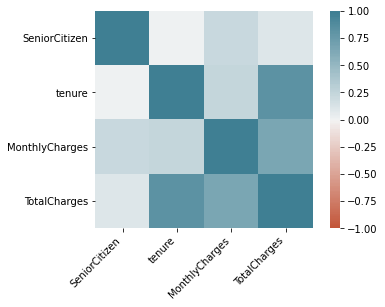

In [ ]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

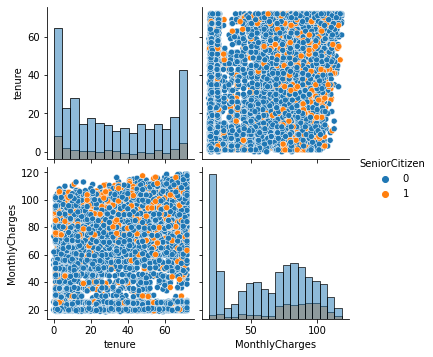

In [13]:
sns.pairplot(df.select_dtypes(include=['int64','float64']), hue = 'SeniorCitizen')
# sns.pairplot only picks numerical relationships
# sns.pairplot(df, hue = "SeniorCitizen")
# The diagonal plot shows the density plot or histogram of a single variable
#sns.pairplot(df.select_dtypes(include=['int64','float64']), hue = 'SeniorCitizen', diag_kind='hist')

In [ ]:
# XGBoost can only take continous variables, therefore, we need to convert the categorical variables in to numerical form
# Let's check the distinct value count in all categorical variables
df.select_dtypes(include=["object"]).nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64

In [ ]:
# One-Hot Encoding method will convert all categorical in to numerical variables

pd.get_dummies(df).head()
# pd.get_dummies(df, columns=['SeniorCitizen']).head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,Churn_No,Churn_Yes
0,0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
4,0,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1


In [ ]:
# Before One-Hot Encoding, let's create separate indep. X variables from dep. Y variable
X = df.drop('Churn', axis = 1).copy()
# alternatively, X = df.iloc[:, :-1]
y = df['Churn'].copy()

In [ ]:
X_enc = pd.get_dummies(X)
display(X_enc.head())
display(X.shape)
display(X_enc.shape)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


(7043, 19)

(7043, 45)

In [ ]:
# Make sure to convert y dep. variable to from categorical to continous
display(y.value_counts())
y = y.apply(lambda x: 1 if x == 'Yes' else 0)
display(y.value_counts())

No     5174
Yes    1869
Name: Churn, dtype: int64

0    5174
1    1869
Name: Churn, dtype: int64

In [ ]:
# Checking if the data is imbalanced or not
sum(y)/ len(y)
# 27% of the customers have left the company. We need to make sure that we maintain the same % across both training and testing datasets
# this kind of splitting the data maintaining the ratio is called "stratification"

0.2653698707936959

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state = 42, stratify = y)
print("train ratio =", sum(y_train)/ len(y_train))
print("test ratio =", sum(y_test)/ len(y_test))


train ratio = 0.2654297614539947
test ratio = 0.26519023282226006


In [ ]:
# Creating the XGBClassfier shell
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
# Adding the data and fitting the model
# Instead of finding the optimal # of tress using K-Cross Validation, let's use early stopping to stop the tree when the cost function no longer reduces
# XGBoost will do the cross validation for us; we just have to specifiy the # of rounds to exhaust with no improvement before stopping
# We use evaluation metric as Area Under Precision-Recall Curve
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.579067
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.581273
[2]	validation_0-aucpr:0.594607
[3]	validation_0-aucpr:0.595215
[4]	validation_0-aucpr:0.596482
[5]	validation_0-aucpr:0.598574
[6]	validation_0-aucpr:0.631769
[7]	validation_0-aucpr:0.638008
[8]	validation_0-aucpr:0.638729
[9]	validation_0-aucpr:0.63937
[10]	validation_0-aucpr:0.63839
[11]	validation_0-aucpr:0.641466
[12]	validation_0-aucpr:0.641945
[13]	validation_0-aucpr:0.641556
[14]	validation_0-aucpr:0.640274
[15]	validation_0-aucpr:0.64372
[16]	validation_0-aucpr:0.645566
[17]	validation_0-aucpr:0.645732
[18]	validation_0-aucpr:0.647367
[19]	validation_0-aucpr:0.64633
[20]	validation_0-aucpr:0.647219
[21]	validation_0-aucpr:0.647022
[22]	validation_0-aucpr:0.647085
[23]	validation_0-aucpr:0.649197
[24]	validation_0-aucpr:0.650565
[25]	validation_0-aucpr:0.649892
[26]	validation_0-aucpr:0.649925
[27]	validation_0-aucpr:0.649745
[28]	validation_0-aucpr:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# So after building 40 trees, the model doesn't improve any longer. So we check for the next 10 iterations and stop

In [ ]:
clf_xgb.base_score

0.5

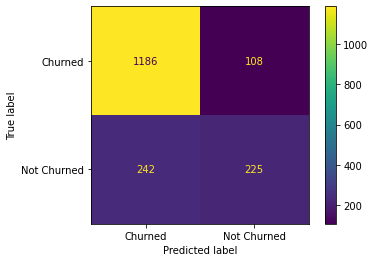

In [ ]:
# Confusion Matrix on the test data
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Churned", "Not Churned"])

In [ ]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.12%


In [ ]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [1428  333]]


In [ ]:
?xgb.plot_tree()

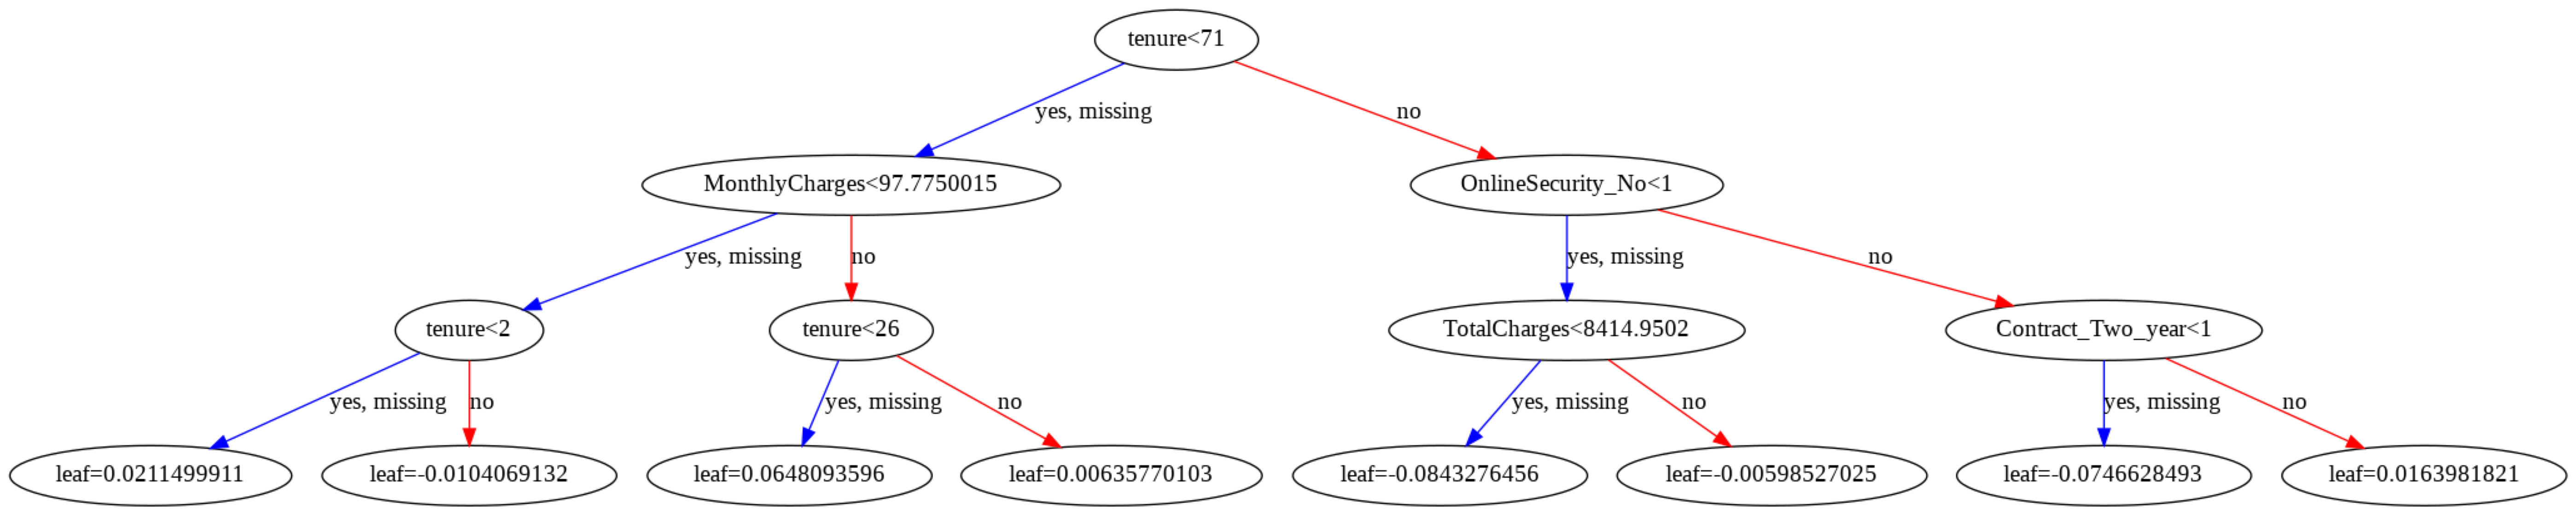

In [ ]:
xgb.plot_tree(clf_xgb,num_trees = 40)
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

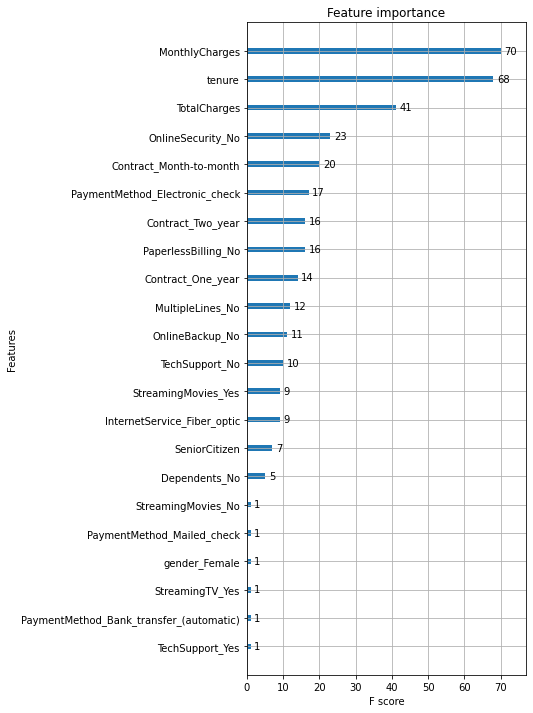

In [ ]:
xgb.plot_importance(clf_xgb)
plt.rcParams['figure.figsize'] = [5, 15]
plt.show()

In [ ]:
# We need to optimize the parameters using Gridsearch
# 

# **2. Using AutoML library in H2O**

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

In [ ]:
X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
6661,0,72,53.65,3784.00,1,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0
4811,0,4,46.00,193.60,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2193,0,56,21.20,1238.65,0,1,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1904,0,56,94.45,5124.60,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0
6667,0,9,79.55,723.40,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0


In [ ]:
# Data prep for h2o; creating h2o frames
X_train_mod = X_train.copy()
X_train_mod['Churn'] = y_train
X_train_mod_hf = h2o.H2OFrame(X_train_mod)

X_test_mod = X_test.copy()
X_test_mod['Churn'] = y_test
X_test_mod_hf = h2o.H2OFrame(X_test_mod)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
## Run AutoML

# Identify predictors and response
x = X_train_mod_hf.columns
y = "Churn"
x.remove(y)

# For binary classification, response should be a factor
X_train_mod_hf[y] = X_train_mod_hf[y].asfactor()
X_test_mod_hf[y] = X_test_mod_hf[y].asfactor()

# Run AutoML for 5 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=5, seed=42)
aml.train(x=x, y=y, training_frame=X_train_mod_hf)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20201109_072459,0.845506,0.421832,0.662047,0.242042,0.368156,0.135539
StackedEnsemble_AllModels_AutoML_20201109_072459,0.845438,0.421786,0.661763,0.239764,0.368038,0.135452
GLM_1_AutoML_20201109_072459,0.844466,0.418354,0.655819,0.235305,0.367871,0.135329
XGBoost_3_AutoML_20201109_072459,0.833802,0.432343,0.646274,0.247328,0.374598,0.140324
XGBoost_2_AutoML_20201109_072459,0.828955,0.441106,0.628862,0.245413,0.378146,0.142994
XGBoost_1_AutoML_20201109_072459,0.823177,0.454658,0.626938,0.25801,0.38232,0.146169
DRF_1_AutoML_20201109_072459,0.816079,0.520198,0.607664,0.261615,0.383895,0.147376


Stacked Ensemble often shows superior results; find the optimium combination of multiple ML models

Stacked Ensemble will consist of two main models:
1. Base Models = [GLM, DRF, XGBoost, GBM] which are more complex and will use training data to be trained, and OOB samples for validation
2. Metal Model = This is a more simpler model which takes the outputs from the above models as input data, and uses test data as output data to train a new ensemble model. Usually for continous problems, linear regression and for categorical problems, logistic regression is used.

Stakced Ensemble although similar to Bagging and Boosting is not the same thing! 

In [ ]:
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
preds = aml.predict(X_test_mod_hf)

# or:
preds = aml.leader.predict(X_test_mod_hf)
preds

stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p0,p1
0,0.883584,0.116416
0,0.924401,0.0755989
0,0.932089,0.0679114
1,0.196197,0.803803
0,0.940458,0.0595421
1,0.200343,0.799657
0,0.842648,0.157352
0,0.942194,0.0578063
1,0.578349,0.421651
1,0.512992,0.487008


In [ ]:
# retrieve the model performance
perf = aml.leader.model_performance(X_test_mod_hf)

perf

#perf.accuracy()


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.1360860858397482
RMSE: 0.36889847633156225
LogLoss: 0.4220480375631373
Null degrees of freedom: 1760
Residual degrees of freedom: 1757
Null deviance: 2037.181774295723
Residual deviance: 1486.4531882973695
AIC: 1494.4531882973695
AUC: 0.8490173722236379
AUCPR: 0.645988668357222
Gini: 0.6980347444472759

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24370503390579165: 


,,0,1,Error,Rate
0,0,993.0,301.0,0.2326,(301.0/1294.0)
1,1,108.0,359.0,0.2313,(108.0/467.0)
2,Total,1101.0,660.0,0.2323,(409.0/1761.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.243705,0.637090,263.0
1,max f2,0.102316,0.757103,342.0
2,max f0point5,0.508567,0.647614,148.0
3,max accuracy,0.508567,0.810903,148.0
4,max precision,0.889222,1.000000,0.0
5,max recall,0.055173,1.000000,397.0
6,max specificity,0.889222,1.000000,0.0
7,max absolute_mcc,0.312373,0.491407,235.0
8,max min_per_class_accuracy,0.243705,0.767388,263.0
9,max mean_per_class_accuracy,0.186399,0.769834,290.0



Gains/Lift Table: Avg response rate: 26.52 %, avg score: 26.53 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010221,0.850664,2.932905,2.932905,0.777778,0.867315,0.777778,0.867315,0.029979,0.029979,193.290507,193.290507,0.026887
1,2,0.020443,0.829493,3.142398,3.037652,0.833333,0.837810,0.805556,0.852563,0.032120,0.062099,214.239829,203.765168,0.056689
2,3,0.030097,0.811595,3.327245,3.130540,0.882353,0.818248,0.830189,0.841556,0.032120,0.094218,232.724524,213.054018,0.087263
3,4,0.040318,0.799956,2.304425,2.921103,0.611111,0.804889,0.774648,0.832260,0.023555,0.117773,130.442541,192.110263,0.105408
4,5,0.050539,0.782609,2.513919,2.838751,0.666667,0.792418,0.752809,0.824202,0.025696,0.143469,151.391863,183.875081,0.126467
5,6,0.100511,0.699690,2.828158,2.833485,0.750000,0.746817,0.751412,0.785728,0.141328,0.284797,182.815846,183.348456,0.250793
6,7,0.150483,0.599823,2.442500,2.703648,0.647727,0.649121,0.716981,0.740364,0.122056,0.406852,144.250049,170.364834,0.348892
7,8,0.200454,0.511285,2.271097,2.595817,0.602273,0.555162,0.688385,0.694195,0.113490,0.520343,127.109694,159.581683,0.435335
8,9,0.300398,0.357293,1.499781,2.231162,0.397727,0.433225,0.591682,0.607369,0.149893,0.670236,49.978100,123.116219,0.503311
9,10,0.400341,0.213337,1.242676,1.984391,0.329545,0.278985,0.526241,0.525390,0.124197,0.794433,24.267569,98.439109,0.536318


In [ ]:
# Get leaderboard with `extra_columns` = 'ALL'
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
StackedEnsemble_BestOfFamily_AutoML_20201109_072459,0.845506,0.421832,0.662047,0.242042,0.368156,0.135539,755,0.027173
StackedEnsemble_AllModels_AutoML_20201109_072459,0.845438,0.421786,0.661763,0.239764,0.368038,0.135452,942,0.027715
GLM_1_AutoML_20201109_072459,0.844466,0.418354,0.655819,0.235305,0.367871,0.135329,3197,0.004213
XGBoost_3_AutoML_20201109_072459,0.833802,0.432343,0.646274,0.247328,0.374598,0.140324,761,0.004956
XGBoost_2_AutoML_20201109_072459,0.828955,0.441106,0.628862,0.245413,0.378146,0.142994,1178,0.005927
XGBoost_1_AutoML_20201109_072459,0.823177,0.454658,0.626938,0.25801,0.38232,0.146169,1205,0.009049
DRF_1_AutoML_20201109_072459,0.816079,0.520198,0.607664,0.261615,0.383895,0.147376,2964,0.021098


To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [ ]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])
print(metalearner)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20201109_072459


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.286E-4 )",5,5,4,levelone_training_StackedEnsemble_AllModels_AutoML_20201109_072459




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.13512307147199065
RMSE: 0.3675909023248408
LogLoss: 0.4207278868370872
Null degrees of freedom: 5281
Residual degrees of freedom: 5276
Null deviance: 6112.964254296836
Residual deviance: 4444.56939654699
AIC: 4456.56939654699
AUC: 0.846868979513802
AUCPR: 0.6639544754854323
Gini: 0.693737959027604

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30237166817968636: 


,,0,1,Error,Rate
0,0,3179.0,701.0,0.1807,(701.0/3880.0)
1,1,417.0,985.0,0.2974,(417.0/1402.0)
2,Total,3596.0,1686.0,0.2117,(1118.0/5282.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.302372,0.637953,230.0
1,max f2,0.121416,0.751742,329.0
2,max f0point5,0.486914,0.642217,160.0
3,max accuracy,0.486914,0.808785,160.0
4,max precision,0.893273,1.000000,0.0
5,max recall,0.055131,1.000000,398.0
6,max specificity,0.893273,1.000000,0.0
7,max absolute_mcc,0.332503,0.495145,218.0
8,max min_per_class_accuracy,0.234542,0.763660,261.0
9,max mean_per_class_accuracy,0.172084,0.766227,295.0



Gains/Lift Table: Avg response rate: 26.54 %, avg score: 26.54 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010034,0.854269,3.483137,3.483137,0.924528,0.868455,0.924528,0.868455,0.034950,0.034950,248.313730,248.313730,0.033919
1,2,0.020068,0.833871,3.127715,3.305426,0.830189,0.843130,0.877358,0.855793,0.031384,0.066334,212.771512,230.542621,0.062983
2,3,0.030102,0.818195,2.914462,3.175105,0.773585,0.826496,0.842767,0.846027,0.029244,0.095578,191.446182,217.510475,0.089134
3,4,0.040136,0.804141,2.772293,3.074402,0.735849,0.811260,0.816038,0.837335,0.027817,0.123395,177.229295,207.440180,0.113344
4,5,0.050170,0.790647,3.412053,3.141932,0.905660,0.797074,0.833962,0.829283,0.034237,0.157632,241.205286,214.193201,0.146292
5,6,0.100151,0.709393,2.611545,2.877240,0.693182,0.750266,0.763705,0.789849,0.130528,0.288160,161.154520,187.723991,0.255943
6,7,0.150133,0.614699,2.326130,2.693768,0.617424,0.660644,0.715006,0.746835,0.116262,0.404422,132.613042,169.376841,0.346175
7,8,0.200114,0.521749,2.126340,2.552046,0.564394,0.570905,0.677389,0.702894,0.106277,0.510699,112.634008,155.204553,0.422812
8,9,0.300076,0.334961,1.648270,2.250977,0.437500,0.422734,0.597476,0.609566,0.164765,0.675464,64.827033,125.097720,0.511031
9,10,0.400038,0.209278,1.113118,1.966647,0.295455,0.264569,0.522007,0.523358,0.111270,0.786733,11.311762,96.664693,0.526424




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.13545190162963655
RMSE: 0.36803790787042107
LogLoss: 0.42178556378485266
Null degrees of freedom: 5281
Residual degrees of freedom: 5276
Null deviance: 6115.425098911919
Residual deviance: 4455.742695823184
AIC: 4467.742695823184
AUC: 0.8454384936100122
AUCPR: 0.661763263718857
Gini: 0.6908769872200244

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3049696332910684: 


,,0,1,Error,Rate
0,0,3179.0,701.0,0.1807,(701.0/3880.0)
1,1,419.0,983.0,0.2989,(419.0/1402.0)
2,Total,3598.0,1684.0,0.212,(1120.0/5282.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.304970,0.637071,233.0
1,max f2,0.116740,0.751174,335.0
2,max f0point5,0.488468,0.642355,156.0
3,max accuracy,0.488468,0.808785,156.0
4,max precision,0.895985,1.000000,0.0
5,max recall,0.052594,1.000000,398.0
6,max specificity,0.895985,1.000000,0.0
7,max absolute_mcc,0.304970,0.493157,233.0
8,max min_per_class_accuracy,0.234635,0.762482,266.0
9,max mean_per_class_accuracy,0.182181,0.766173,293.0



Gains/Lift Table: Avg response rate: 26.54 %, avg score: 26.54 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010034,0.853618,3.483137,3.483137,0.924528,0.867744,0.924528,0.867744,0.034950,0.034950,248.313730,248.313730,0.033919
1,2,0.020068,0.834984,3.127715,3.305426,0.830189,0.843234,0.877358,0.855489,0.031384,0.066334,212.771512,230.542621,0.062983
2,3,0.030102,0.819751,2.843377,3.151410,0.754717,0.826833,0.836478,0.845937,0.028531,0.094864,184.337739,215.140994,0.088163
3,4,0.040136,0.804321,2.914462,3.092173,0.773585,0.811322,0.820755,0.837283,0.029244,0.124108,191.446182,209.217291,0.114315
4,5,0.050170,0.790010,3.198800,3.113498,0.849057,0.796750,0.826415,0.829177,0.032097,0.156205,219.879956,211.349824,0.144350
5,6,0.100151,0.709363,2.640087,2.877240,0.700758,0.750436,0.763705,0.789881,0.131954,0.288160,164.008667,187.723991,0.255943
6,7,0.150133,0.615022,2.283318,2.679516,0.606061,0.660256,0.711223,0.746727,0.114123,0.402282,128.331820,167.951566,0.343262
7,8,0.200114,0.520856,2.126340,2.541353,0.564394,0.570574,0.674551,0.702731,0.106277,0.508559,112.634008,154.135260,0.419899
8,9,0.300076,0.332690,1.662541,2.248600,0.441288,0.421516,0.596845,0.609052,0.166191,0.674750,66.254107,124.860024,0.510060
9,10,0.400038,0.210470,1.127388,1.968430,0.299242,0.265040,0.522480,0.523089,0.112696,0.787447,12.738836,96.842993,0.527395




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.791326,0.023188112,0.7815356,0.8216266,0.7806268,0.8084906,0.7643505
1,auc,0.84651506,0.016425924,0.8283873,0.86617494,0.8355068,0.86120397,0.84130234
2,aucpr,0.6634538,0.027199196,0.64238673,0.69254875,0.6683308,0.68494594,0.6290568
3,err,0.20867398,0.023188112,0.21846434,0.17837338,0.21937323,0.19150944,0.23564954
4,err_count,220.0,20.59126,239.0,193.0,231.0,203.0,234.0
5,f0point5,0.61144495,0.031231271,0.6091954,0.63728815,0.6093936,0.63935447,0.56199306
6,f1,0.64673287,0.018469322,0.63951737,0.66080844,0.6396256,0.6699187,0.6237942
7,f2,0.687316,0.014643139,0.6730159,0.68613136,0.6730138,0.7035519,0.70086706
8,lift_top_group,3.3515162,0.35031807,2.944378,3.6840312,3.2560296,3.745583,3.127559
9,logloss,0.42180187,0.025813486,0.45086232,0.38571665,0.4400205,0.40832707,0.42408285



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-11-09 07:26:07,0.000 sec,0,3056.482127,0.578660,,,,,,,
1,,2020-11-09 07:26:07,0.006 sec,1,2262.282814,0.429035,,,,,,,
2,,2020-11-09 07:26:07,0.009 sec,2,2223.067031,0.421760,,,,,,,
3,,2020-11-09 07:26:07,0.012 sec,3,2222.284936,0.421653,,,,,,,
4,,2020-11-09 07:26:07,0.015 sec,4,2222.284698,0.421652,0.367591,0.420728,0.306979,NaN,NaN,3.48314,0.211662


Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [ ]:
metalearner.coef_norm()

{'DRF_1_AutoML_20201109_072459': 0.017365953712936106,
 'GLM_1_AutoML_20201109_072459': 0.9865903689567186,
 'Intercept': -1.367243929776935,
 'XGBoost_1_AutoML_20201109_072459': 0.17374877639018102,
 'XGBoost_2_AutoML_20201109_072459': 0.026493549709962445,
 'XGBoost_3_AutoML_20201109_072459': 0.22434773588967197}

We can also plot the base learner contributions to the ensemble.



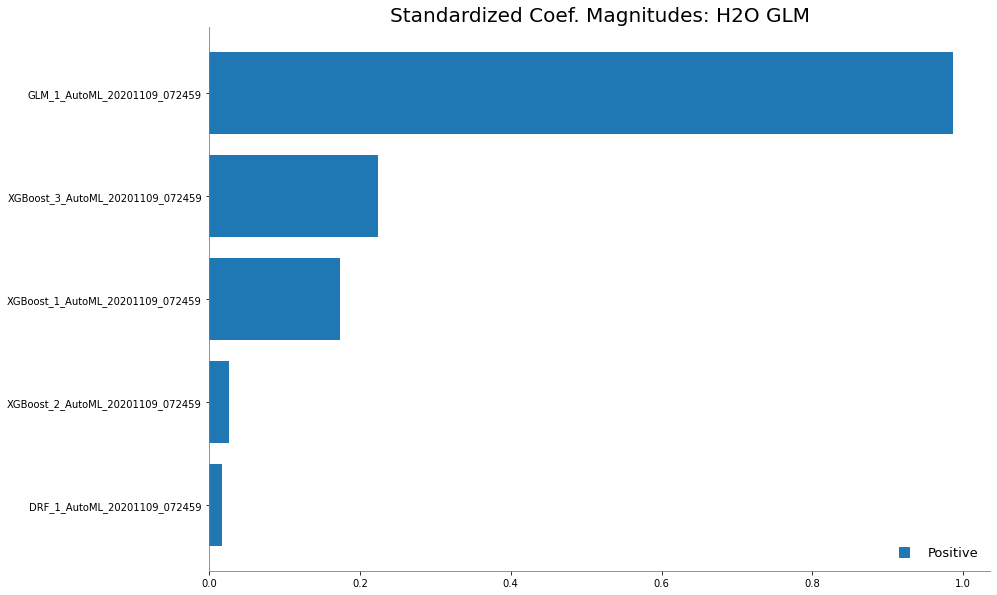

In [ ]:
%matplotlib inline
metalearner.std_coef_plot()

Looks like Logistic Regression model is the highest contributor